<a href="https://colab.research.google.com/github/ncsu-geoforall-lab/geomorphometry2025_workshop/blob/main/geomorphometry_2025_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workshop: Propagating DEM Uncertainty to Stream Extraction using GRASS

### Abstract

GRASS is an open-source geospatial processing engine. With over 400 tools available in the core distribution and an additional 400+ tools available as extensions, GRASS has broad applicability in the Earth Sciences and geomorphometry in particular. In this workshop, we will give an introduction to GRASS and demonstrate some of the geomorphometry tools available in GRASS. Specifically, we will show how to compute stream extraction uncertainty using a workflow adapted from Hengl (2007) [1] and Hengl (2010) [2]. In this tutorial, we will:
* [Create a new GRASS project](#start)
* [Download and import elevation data](#data) of near Perugia using GRASS data fetching tools
* [Use R’s kriging functions (gstat)](#R) to create 100 iterations of a DEM
* [Extract streams](#uncert) from each of the 100 DEMs to compute stream uncertainty

Check out the publication associated with the notebook on Zenodo:

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.15283714.svg)](https://doi.org/10.5281/zenodo.15283714)


---


### Install GRASS and Get Workshop Materials

The following cell installs GRASS from the ubuntugis-unstable ppa. It will take a minute to run.

In [1]:
!add-apt-repository -y ppa:ubuntugis/ubuntugis-unstable
!apt update
!apt-get install -y grass-core grass-dev

PPA publishes dbgsym, you may need to include 'main/debug' component
Repository: 'deb https://ppa.launchpadcontent.net/ubuntugis/ubuntugis-unstable/ubuntu/ jammy main'
Description:
Unstable releases of Ubuntu GIS packages. These releases are more bleeding edge and while generally they should work well, they dont receive the same amount of quality assurance as our stable releases do.
More info: https://launchpad.net/~ubuntugis/+archive/ubuntu/ubuntugis-unstable
Adding repository.
Adding deb entry to /etc/apt/sources.list.d/ubuntugis-ubuntu-ubuntugis-unstable-jammy.list
Adding disabled deb-src entry to /etc/apt/sources.list.d/ubuntugis-ubuntu-ubuntugis-unstable-jammy.list
Adding key to /etc/apt/trusted.gpg.d/ubuntugis-ubuntu-ubuntugis-unstable.gpg with fingerprint 2EC86B48E6A9F326623CD22FFF0E7BBEC491C6A1
Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cr

We can check GRASS installed and see what version we have using:

In [2]:
!grass --version

GRASS GIS 8.4.1
Geographic Resources Analysis Support System (GRASS) is Copyright,
1999-2025 by the GRASS Development Team, and licensed under terms of the
GNU General Public License (GPL) version >=2.

This GRASS GIS 8.4.1 release is coordinated and produced by
the GRASS Development Team with contributions from all over the world.

This program is distributed in the hope that it will be useful, but
WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU
General Public License for more details.


In [3]:
!git clone https://github.com/ncsu-geoforall-lab/geomorphometry2025_workshop.git

Cloning into 'geomorphometry2025_workshop'...
remote: Enumerating objects: 222, done.
remote: Counting objects: 100% (222/222), done.
remote: Compressing objects: 100% (160/160), done.
remote: Total 222 (delta 88), reused 160 (delta 46), pack-reused 0 (from 0)
Receiving objects: 100% (222/222), 17.22 MiB | 19.28 MiB/s, done.
Resolving deltas: 100% (88/88), done.


<a name="start"></a>

---

## Create a New GRASS Project and Start GRASS

First, let's import all the Python libraries we'll need.

In [4]:
import sys
import subprocess
import pandas as pd
from IPython.display import display
from ipyleaflet import WMSLayer, Marker

**Importing the GRASS Python API**

We are going to import the GRASS Python API (`grass.script`) and the GRASS Jupyter package (`grass.jupyter`). But first, we'll need to ask `grass` to check it's `--config` to see where the python packages are then add them to the system path before we can import them.

We use `subprocess.check_output` to find the path and `sys.path.append` to add it to the path.

In [5]:
sys.path.append(
    subprocess.check_output(["grass", "--config", "python_path"], text=True).strip()
)

Then, we can import the Python API and GRASS Jupyter packages.

In [6]:
import grass.script as gs
import grass.jupyter as gj

**Starting a New Project**

Now, we create a new project called "geomorphometry_workshop". Projects are defined by a Coordinate Reference System (CRS). We can set the CRS from a georeferenced file (such as a Geotiff) or an EPSG string. Here, we use [EPSG 32632](https://epsg.io/32632), CRS WGS 84/UTM zone 32N (EPSG:32632).

In [7]:
gs.create_project("geomorphometry_workshop", epsg="32632")

You should now see a new folder created called "geomorphometry_workshop". This will contain all of the data for our project and is organized by GRASS's native data format. This makes GRASS _fast_, _scalable_, and _avoids projection mismatches_.

We start a GRASS session in our new project.

In [8]:
gj.init("geomorphometry_workshop");

**Introducting the "Computational Region"**

Finally, let's set our computational region using [`g.region`](https://grass.osgeo.org/grass85/manuals/g.region.html). The computational region will determine what data is imported from the cloud so we need to set it before continuing.

Upon creating a project, the computational region is empty.

In [9]:
print(gs.read_command("g.region", flags="p"))

projection: 1 (UTM)
zone:       32
datum:      wgs84
ellipsoid:  wgs84
north:      1
south:      0
west:       0
east:       1
nsres:      1
ewres:      1
rows:       1
cols:       1
cells:      1



There are lots of ways to set the computional region, from a georeferenced file or existing data layer to relative operations grow which adds cells around the previous region. Here, we set our computational region with coordinates and set the resolution to 10 meters.

In [10]:
aoi_bbox = {
	"north": 4779210,
	"south": 4778120,
	"west": 779180,
	"east": 780630
}

print(
    gs.read_command(
        "g.region", n=aoi_bbox["north"], s=aoi_bbox["south"], e=aoi_bbox["east"], w=aoi_bbox["west"], res=10, flags="p"
    )
)

projection: 1 (UTM)
zone:       32
datum:      wgs84
ellipsoid:  wgs84
north:      4779210
south:      4778120
west:       779180
east:       780630
nsres:      10
ewres:      10
rows:       109
cols:       145
cells:      15805



<a name="data"></a>

---

## Download and Import Data

Right now, our project has no data in it:

In [11]:
gs.read_command("g.list", type="all")

''

We're going to use a DEM from the TINItaly dataset. Let's get an overview of the dataset using a quick WMS visualization.

First, let's create some WMSLayers:

In [12]:
tinitaly_wms = WMSLayer(
    name="TINItaly_1.1 HSV (WMS)",
    url="http://tinitaly.pi.ingv.it/TINItaly_1_1/wms?service=WMS",
    layers="TINItaly_1.1:tinitaly_hsv",
    format="image/png",
    transparent=True,
    attribution="HSV Elevation Data © 2023 TINItaly 1.1",
)

tinitaly_slope = WMSLayer(
    name="TINItaly_1.1 Slope (WMS)",
    url="http://tinitaly.pi.ingv.it/TINItaly_1_1/wms?service=WMS",
    layers="TINItaly_1.1:tinitaly_slope",
    format="image/png",
    transparent=True,
    attribution="Slope Data © 2023 TINItaly 1.1",
)

nasa_wms = WMSLayer(
    name="NASA SRTM RAMP2 TOPO (WMS)",
    url="https://neo.gsfc.nasa.gov/wms/wms?service=WMS",
    layers="SRTM_RAMP2_TOPO",
    format="image/png",
    transparent=True,
    styles="rgb",
    attribution="SRTM RAMP2 TOPO © 2025 NASA ",
)

perugia = Marker(
    name="Perugia (Marker)",
    location=(43.11203, 12.38914),
    draggable=False,
    title="Perugia",
    alt="Perugia",
    # icon="fa-flag",
)

And create a vector box of our region to add:

In [13]:
gs.run_command("v.in.region", output="region")

In [14]:
nasa_basemap = "NASAGIBS BlueMarble"
m = gj.InteractiveMap(height=600, width=800, tiles=nasa_basemap, use_region=True)
m.map.add(tinitaly_wms)
m.map.add(tinitaly_slope)
m.map.add(nasa_wms)
m.map.add(perugia)
m.add_vector("region")
m.add_layer_control()
m.map.zoom = 6
m.map.center = (43.11203, 12.38914)
display(m.show())

Map(center=[43.11203, 12.38914], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…

Now we can import our DEM. We will use the [r.import](https://grass.osgeo.org/manuals/grass85/r.import.html) command to import a DEM file. The DEM file is a [Cloud Optimized GeoTIFF (COG)](https://cogeo.org/), and we will specify the output name as "dem". *r.import* will automatically reproject the DEM to the project's CRS.

In [15]:
gs.run_command(
    "r.import",
    input="https://storage.googleapis.com/geomorphometry/w47575_s10.cog.tif",
    output="dem",
    title="TINItaly DEM 10m",
    resample="bicubic_f",
    resolution="region",
    extent="region",
    overwrite=True,
)

Let's get some basic information about our DEM. We'll use the [`r.info`](https://grass.osgeo.org/grass85/manuals/r.info.html) and [`r.univar`](https://grass.osgeo.org/grass85/manuals/r.univar.html) tools to get the rasters metadata and univariate statistics respectively.

In [16]:
print(gs.read_command("r.info", map="dem"))

 +----------------------------------------------------------------------------+
 | Map:      dem                            Date: Mon Jun  2 16:19:14 2025    |
 | Mapset:   PERMANENT                      Login of Creator: root            |
 | Project:  geomorphometry_workshop                                          |
 | DataBase: /content                                                         |
 | Title:                                                                     |
 | Timestamp: none                                                            |
 |----------------------------------------------------------------------------|
 |                                                                            |
 |   Type of Map:  raster               Number of Categories: 0               |
 |   Data Type:    FCELL                Semantic label: (none)                |
 |   Rows:         109                                                        |
 |   Columns:      145                  

**Try it yourself!**

Using the cell above as a template, compute the univariate statistics using [`r.univar`](https://grass.osgeo.org/grass85/manuals/r.univar.html).

<details>
    <summary>👉 <b>click to see hint</b></summary>
  
Run `!r.univar --help` to see the paramters.
</details>


<details>
    <summary>👉 <b>click to see solution</b></summary>
    
```python
print(gs.read_command("r.univar", map="dem", flags="e"))
```
</details>


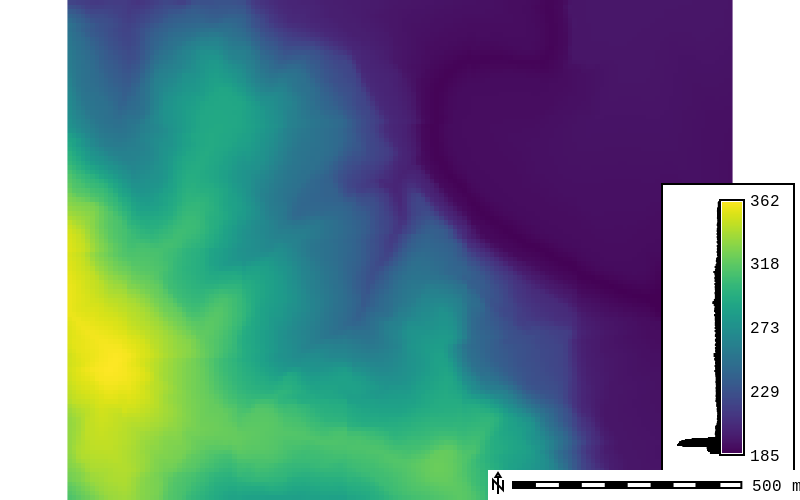

In [17]:
m = gj.Map(use_region=True, height=500, width=800)
m.d_rast(map="dem")
m.d_legend(raster="dem", flags="bds", at="9,60,90,93", fontsize=16)
m.d_barscale(at="61,6", fontsize=16, flags="n")
m.show()

Compute some other common DEM derivatives: shaded relief, slope and aspect.

In [18]:
gs.run_command("r.relief", input="dem", output="relief", scale=1, zscale=1)

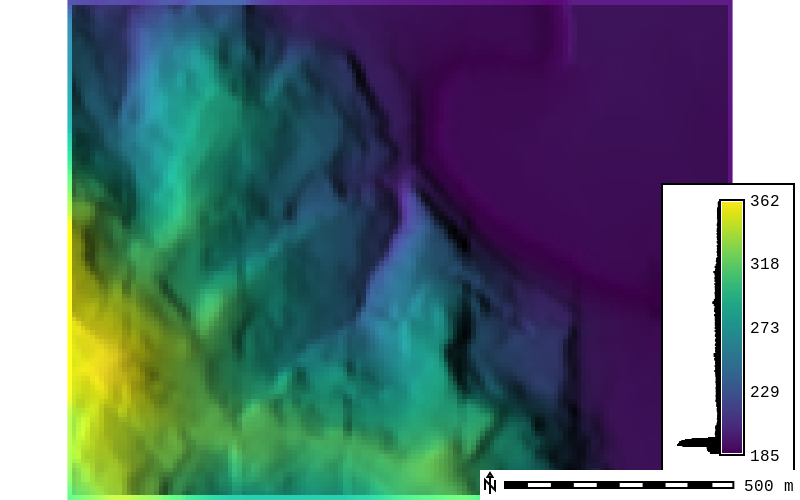

In [19]:
m = gj.Map(use_region=True, height=500, width=800)
m.d_shade(shade="relief", color="dem", brighten=30)
m.d_legend(raster="dem", flags="bds", at="9,60,90,93", fontsize=16)
m.d_barscale(at="60,6", fontsize=16, flags="n")
m.show()


**Try it yourself!**

Compute and display the slope and aspect using [`r.slope.aspect`](https://grass.osgeo.org/grass85/manuals/r.slope.aspect.html). Try changing the color map for the slope raster using [`r.colors`](https://grass.osgeo.org/grass85/manuals/r.colors.html). _Bonus Challenge_: Can you add a legend to your visualization with a histogram showing the range of slope values?

<details>
    <summary>👉 <b>click to see hint</b></summary>
  
Looking at the manual for r.slope.aspect, your code should be formatted like:

```python
gs.run_command("r.slope.aspect", elevation=.., slope=.., aspect=..)
```

To get the legend and histogram, look at the flag options in `d.legend`. Remember that `d.legend` can be called by `grass.jupyter.Map()` with `m.d_legend()`. See above for examples.

</details>


<details>
    <summary>👉 <b>click to see solution</b></summary>
    
```python
gs.run_command("r.slope.aspect", elevation="dem", slope="slope", aspect="aspect")

gs.run_command("r.colors", map="slope", color="sepia", flags="e")

m = gj.Map(use_region=True)
m.d_rast(map="slope")
m.d_legend(raster="slope", flags="bds")
m.show()
```

And for aspect:

```python
m = gj.Map(use_region=True)
m.d_rast(map="aspect")
m.d_legend(raster="aspect", flags="bds")
m.show()
```
</details>


Since we're going to interpolate surfaces from points, we'll randomly sample points from the DEM. We could think of these as LiDAR points or ground sampled points.

In [20]:
gs.run_command("r.random", input="dem", vector="elev_points", n=500, flags="s")

Now, visualize the points.

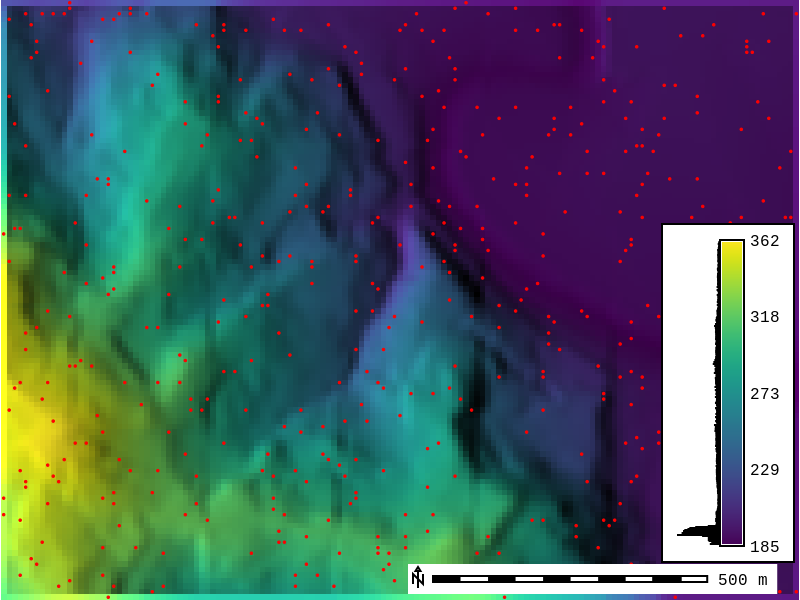

In [21]:
m = gj.Map(use_region=True, height=600, width=800)
m.d_shade(shade="relief", color="dem", brighten=30)
m.d_vect(map="elev_points", color="red", fillcolor="red", icon="basic/point")
m.d_legend(raster="dem", flags="bds", at="9,60,90,93", fontsize=16)
m.d_barscale(at="51,6", fontsize=16, flags="n")
m.show()

<a name="R"></a>

---

## Conditional Gaussian Simulations in R

To do our Conditional Gaussian simulations, we'll move to R. We're going to use the `rgrass` library to read and write data to/from GRASS and we'll use `gstat` to do simulate 100 DEMs.

**Install and Import R LIbraries**

First, load the rpy2 extension. rpy2 is an interface to R running embedded in a Python process allowing up to continue operating in our current Python session but cells in R. Fancy! This is only necessary here because we're using R from within our Python process. Check out [here](https://grass-tutorials.osgeo.org//content/tutorials/get_started/fast_track_grass_and_R.html) for an introduction for GRASS in R.

In [22]:
%load_ext rpy2.ipython

Now, we can use the %%R cell magic. When this cell is interpreted, it's contents will be sent to R. We could also use line magic now with %R which would only send the line to R.

In [23]:
%%R
system("apt-get install r-cran-sf r-cran-rgrass r-cran-gstat r-cran-terra r-cran-devtools r-cran-irkernel")

We also need some other functions to help parameterize our Matern Covariance variogram. Dr. Corey White has drafted a package to help with this. We load it here:

In [24]:
%%R
devtools::load_all("geomorphometry2025_workshop/cgsSim/")

ℹ Loading cgsSim
ℹ The packages "future", "future.apply", and "optparse" are required.
✖ Would you like to install them?

1: Yes
2: No

Selection: Yes
future       (NA -> 1.49.0) [CRAN]
optparse     (NA -> 1.7.5 ) [CRAN]
future.apply (NA -> 1.11.3) [CRAN]


Installing 3 packages: future, optparse, future.apply
Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
also installing the dependencies ‘globals’, ‘listenv’, ‘parallelly’, ‘getopt’

trying URL 'https://cran.rstudio.com/src/contrib/globals_0.18.0.tar.gz'
trying URL 'https://cran.rstudio.com/src/contrib/listenv_0.9.1.tar.gz'
trying URL 'https://cran.rstudio.com/src/contrib/parallelly_1.44.0.tar.gz'
trying URL 'https://cran.rstudio.com/src/contrib/getopt_1.20.4.tar.gz'
trying URL 'https://cran.rstudio.com/src/contrib/future_1.49.0.tar.gz'
trying URL 'https://cran.rstudio.com/src/contrib/optparse_1.7.5.tar.gz'
trying URL 'https://cran.rstudio.com/src/contrib/future.apply_1.11.3.tar.gz'

The downloaded source packages are in
	‘/tmp/Rtmpk0GDV8/downloaded_packages’
cgsSim 0.1.0


Load other libraries.

In [25]:
%%R
library(sf)
library(gstat)
library(terra)
library(rgrass)

Linking to GEOS 3.12.1, GDAL 3.4.3, PROJ 8.2.1; sf_use_s2() is TRUE
Linked against: 3.12.1-CAPI-1.18.1 compiled against: 3.10.2-CAPI-1.16.0
It is probably a good idea to reinstall sf (and maybe lwgeom too)
terra 1.8.54
Compiled with:3.10.2-CAPI-1.16.0
 Running with:3.12.1-CAPI-1.18.1

You should reinstall package 'terra'


Attaching package: ‘terra’

The following objects are masked from ‘package:testthat’:

    compare, describe

GRASS GIS interface loaded with GRASS version: GRASS 8.4.1 (2025)
and location: geomorphometry_workshop


**Create Empirical (sample) Variogram**

Use readVECT from rgrass to turn the random elevation points into a [SpatVector](https://rdrr.io/cran/terra/man/SpatVector-class.html), the terra vector class.

In [26]:
%%R
elev_points <- rgrass::read_VECT("elev_points")

Exporting 500 features...
   5%  11%  17%  23%  29%  35%  41%  47%  53%  59%  65%  71%  77%  83%  89%  95% 100%
v.out.ogr complete. 500 features (Point type) written to <elev_points>
(GPKG format).


Compute the cutoff and width of the empirical variogram by using the maximum distance between two points. CITATION?

In [27]:
%%R

coords <- terra::geom(elev_points)[, c("x", "y")]
dists <- as.matrix(dist(coords))
max_dist <- max(dists)

# By default, gstat uses a cutoff of "the length of the diagonal of the box spanning the data is divided by three."
# Try increasing this to 0.6 or 0.7:
cutoff <- 0.33 * max_dist #<--Modify this coefficient

width <- cutoff / 20
print(paste("Using cutoff:", cutoff, "and width:", width))

[1] "Using cutoff: 583.503084824751 and width: 29.1751542412375"


With the width and cutoff, we can computate the variogram. First, convert to random sample points to an `sf` dataframe since that is the input format for `gstat`.

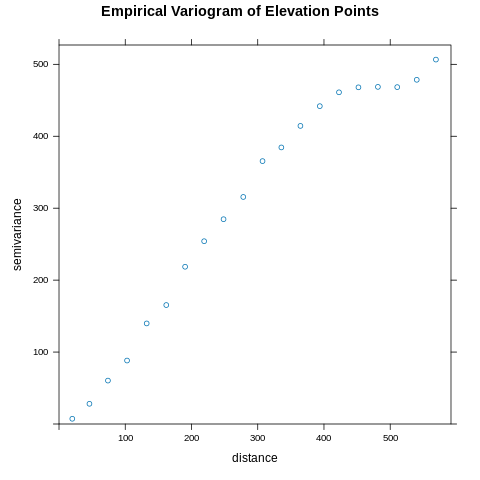

In [28]:
%%R
elev_df <- terra::as.data.frame(elev_points, geom = "XY")
g <- gstat::gstat(formula = value ~ x + y, locations = ~x + y, data = elev_df)
vg <- gstat::variogram(g, cutoff=cutoff, width=width)


plot(vg, main = "Empirical Variogram of Elevation Points")

Now, we're going to fit a Matern Covariance function to the empirical variogram. First, we'll fit Kappa using `cgSim` library that Dr. Corey White has been working on. We pass the empirical variogram as the input.

In [29]:
%%R
# Fit kappa
fit_kappa <- optimize_kappa(vg)
fit_kappa

$model
  model      psill    range    kappa
1   Nug   4.548204   0.0000 0.000000
2   Mat 544.302815 129.4577 1.695719

$kappa
[1] 1.695719

$SSErr
[1] 55.46788



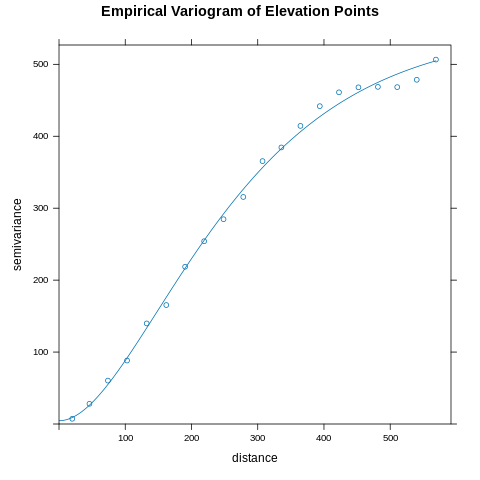

In [30]:
%%R
plot(vg, model = fit_kappa$model, main = "Empirical Variogram of Elevation Points")

Let's see some information about our fitted variogram:

In [31]:
%%R
head(fit_kappa)

$model
  model      psill    range    kappa
1   Nug   4.548204   0.0000 0.000000
2   Mat 544.302815 129.4577 1.695719

$kappa
[1] 1.695719

$SSErr
[1] 55.46788



In [32]:
%%R
vfit <- gstat::fit.variogram(vg, model = fit_kappa$model, fit.kappa = FALSE)

Time to interpolate our DEMs using the fitted variogram. We will only do 10 simulations since the process is computationally intensive but in the GitHub repo, we've included a set of 90 pre-computed simulations that we'll import after this for computed extracted stream uncertainty.

Create a 10m resolution grid for prediction:

TODO: Can it be less than 10m so that it runs faster? What about 30m?

In [33]:
%%R
grid_ext <- terra::ext(elev_points)
grid_res <- 10

xy <- expand.grid(
  x = seq(grid_ext[1], grid_ext[2], by = grid_res),
  y = seq(grid_ext[3], grid_ext[4], by = grid_res)
)

Run 2 stochastic conditional gaussian simulations, creating 10 DEMs. The `run_sim` tool is part of `cgSim` which uses `gstat::predict` on the backend.

(This is taking ~2 hours to run on Colab. Perhaps we reduce the resolution?)

In [ ]:
%%R
run_sim(
  elev_df,
  fitmodel = vfit, #fit_kappa$model
  nsim = 2,
  newdata=xy,
  nmin = 10,
  nmax = 40,
  distmax = 1000,
);

The `run_sim` function writes these rasters into GRASS. Use the GRASS R API to list the simulated rasters:

In [35]:
%%R
execGRASS("g.list", type="raster", pattern="sgs_sim_*")

sgs_sim_1
sgs_sim_2


Let's rename them so that we can import the other 100 pre-computed runs without any name conflicts.

In [37]:
!g.rename raster=sgs_sim_1,sgs_sim_1_test

Rename raster <sgs_sim_1> to <sgs_sim_1_test>


In [38]:
!g.rename raster=sgs_sim_2,sgs_sim_2_test

Rename raster <sgs_sim_2> to <sgs_sim_2_test>


Import the pre-computed simulations:

In [40]:
%%R
execGRASS("r.unpack", input="geomorphometry2025_workshop/runs.pack")

Raster map <sgs_sim_100> unpacked


In [41]:
%%R
execGRASS("g.list", type="raster", pattern="sgs_sim_*")

sgs_sim_100
sgs_sim_1_test
sgs_sim_2_test


Calculate the mean and standard deviation of the simulatate surfaces

In [42]:
%%R
execGRASS("g.list", type="raster", pattern="sgs_sim_*", output="tmp_list_simulated.txt")
execGRASS("r.series", file="tmp_list_simulated.txt", output="simulated_mean", method="average")
execGRASS("r.series", file="tmp_list_simulated.txt", output="simulated_std", method="stddev")

   0%   3%   6%   9%  12%  15%  18%  21%  24%  27%  30%  33%  36%  39%  42%  45%  48%  51%  54%  57%  60%  63%  66%  69%  72%  75%  78%  81%  84%  87%  90%  93%  96%  99% 100%
   0%   3%   6%   9%  12%  15%  18%  21%  24%  27%  30%  33%  36%  39%  42%  45%  48%  51%  54%  57%  60%  63%  66%  69%  72%  75%  78%  81%  84%  87%  90%  93%  96%  99% 100%


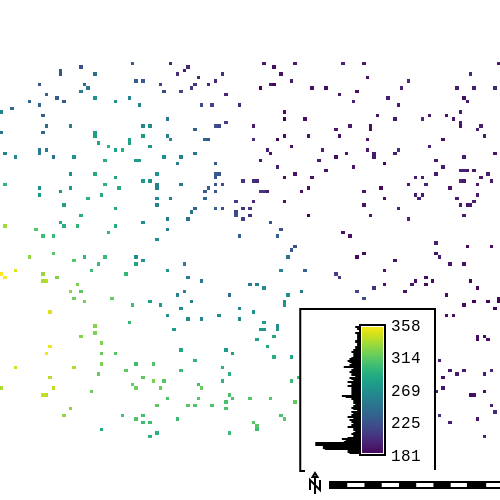

In [43]:
m = gj.Map(use_region=True, height=500, width=500)
m.d_rast(map="simulated_mean")
m.d_legend(raster="simulated_mean", flags="bds", at="9,35,72,77", fontsize=16)
m.d_barscale(at="61,6", fontsize=16, flags="n")
m.show()

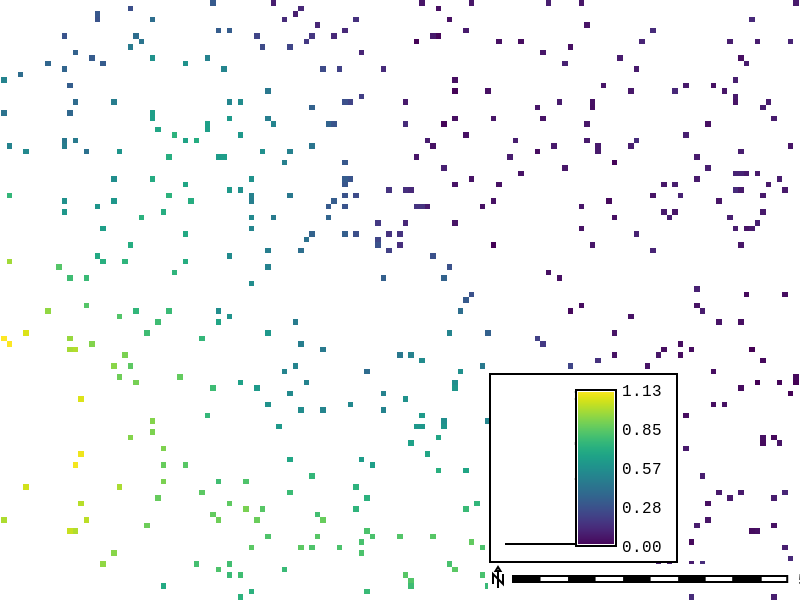

In [44]:
m = gj.Map(use_region=True, height=600, width=800)
m.d_rast(map="simulated_mean")
m.d_legend(raster="simulated_std", flags="bds", at="9,35,72,77", fontsize=16)
m.d_barscale(at="61,6", fontsize=16, flags="n")
m.show()

<a name="uncert"></a>

---

## Extract Streams and Compute Uncertainty

Generate streams for each DEM

In [ ]:
%%R
N.sim <- 10
for(i in 1:N.sim) {execGRASS("r.watershed", elevation=paste("sgs_sim_", i, sep=""),
 threshold=10000, stream=paste("stream_", i, sep=""), flags=c("quiet"))}

Calculate the probablity and error

INSERT EQUATION AND CITATION

In [ ]:
%%R
execGRASS("g.list", type="raster", pattern="stream*", output="tmp_list_stream.txt")
execGRASS("r.series", file="tmp_list_stream.txt", output="count", method="count")
execGRASS("r.mapcalc", expression=paste("prob = float(count)/", N.sim))
execGRASS("r.mapcalc", expression="error = -prob * log(prob) - (1-prob)* log(1-prob)")

Probability that a cell contains a stream:

In [ ]:
m =gj.Map()
m.d_shade(shade="relief", color="prob", brighten=30)
m.show()

Stream error:

In [ ]:
m =gj.Map()
m.d_shade(shade="relief", color="error", brighten=30)
m.show()